<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><ul class="toc-item"><li><span><a href="#Preliminaries" data-toc-modified-id="Preliminaries-0.1"><span class="toc-item-num">0.1&nbsp;&nbsp;</span>Preliminaries</a></span></li></ul></li><li><span><a href="#Multimission-Simulation" data-toc-modified-id="Multimission-Simulation-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Multimission Simulation</a></span></li><li><span><a href="#WFC3-simulation-and-observed-image" data-toc-modified-id="WFC3-simulation-and-observed-image-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>WFC3 simulation and observed image</a></span></li><li><span><a href="#Slitless-spectra-from-multi-missions-JWST/NIRISS-and-WFIRST" data-toc-modified-id="Slitless-spectra-from-multi-missions-JWST/NIRISS-and-WFIRST-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Slitless spectra from multi-missions <em>JWST</em>/NIRISS and <em>WFIRST</em></a></span><ul class="toc-item"><li><span><a href="#WFC3/IR-G141" data-toc-modified-id="WFC3/IR-G141-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>WFC3/IR G141</a></span></li><li><span><a href="#JWST-NIRISS" data-toc-modified-id="JWST-NIRISS-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>JWST NIRISS</a></span></li><li><span><a href="#Roman/G150-Grism" data-toc-modified-id="Roman/G150-Grism-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>Roman/G150 Grism</a></span><ul class="toc-item"><li><span><a href="#Roman-HLS-depth" data-toc-modified-id="Roman-HLS-depth-3.3.1"><span class="toc-item-num">3.3.1&nbsp;&nbsp;</span>Roman HLS depth</a></span></li></ul></li><li><span><a href="#Pull-out-an-object-and-simulate-a-spectrum-with-lines" data-toc-modified-id="Pull-out-an-object-and-simulate-a-spectrum-with-lines-3.4"><span class="toc-item-num">3.4&nbsp;&nbsp;</span>Pull out an object and simulate a spectrum with lines</a></span></li></ul></li><li><span><a href="#Compare-Grizli-and-Pandeia-simulations-for-Roman" data-toc-modified-id="Compare-Grizli-and-Pandeia-simulations-for-Roman-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Compare Grizli and Pandeia simulations for Roman</a></span></li></ul></div>

In [23]:
%matplotlib inline

## Preliminaries 

Install dependencies for running on cloud notebook servers like [Google Collab](https://colab.research.google.com/).


In [24]:
try:
    import grizli
except:
    0
#     with open('requirements.txt','w') as fp:
#         fp.write("""
# cython
# tqdm
# astropy==4.2.1
# drizzlepac==3.2.1
# photutils==1.0.2
# grizli>=1.3""")

#     !pip install -r requirements.txt

In [25]:
import os
import glob
import grizli
import grizli.utils

# Make directories
for sub in ['CONF','iref','jref','templates']:
    dir = os.path.join(grizli.GRIZLI_PATH, sub)
    if not os.path.exists(dir):
        print(f'mkdir {dir}')
        os.mkdir(dir)

for sub in ['iref','jref']:
    if not os.getenv(sub):
        print(f'set {sub}')
        os.environ[sub] = os.path.join(grizli.GRIZLI_PATH, sub)

if len(glob.glob(os.path.join(grizli.GRIZLI_PATH, 'CONF/*'))) == 0:
    print('Fetch')
    grizli.utils.fetch_default_calibs(ACS=False) # to iref/iref
    grizli.utils.fetch_config_files()            # to $GRIZLI/CONF

if len(glob.glob(os.path.join(grizli.GRIZLI_PATH, 'templates/*'))) == 0:
    print('link templates')
    grizli.utils.symlink_templates(force=False)

In [26]:
# Pysynphot
pysyn_cdbs = os.getenv('PYSYN_CDBS')
if not pysyn_cdbs:
    pysyn_cdbs = os.path.join(grizli.GRIZLI_PATH, 'cdbs')
    if not os.path.exists(pysyn_cdbs):
        os.mkdir(pysyn_cdbs)
    
    os.environ['PYSYN_CDBS'] = pysyn_cdbs
    
if not os.path.exists(os.path.join(pysyn_cdbs, 'comp')):
    pwd = os.getcwd()
    os.chdir(pysyn_cdbs)

    os.system('wget http://ssb.stsci.edu/trds/tarfiles/synphot1.tar.gz')
    os.system('tar xzf synphot1.tar.gz')
    os.system('ln -s grp/redcat/trds/* .')
    os.system('rm synphot1.tar.gz')
    
    os.chdir(pwd)

try:
    import pysynphot as S
except:
    ! pip install pysynphot
    
import pysynphot as S
bp = S.ObsBandpass('wfc3,ir,f140w')

# Multimission Simulation

This notebook demonstrates two analysis capabilities of the `grizli` software:

1. The capability of providing a reference image and SExtractor-like segmentation file created entirely independently from any given grism exposure.  The reference image is typically much deeper than a single direct image taken accompanying a grism exposure.  The code assumes that the grism file is astrometrically aligned to the reference image, but the reference image can have any pixel scale.

2. Simulation tools for comparison of slitless spectroscopy from a number of different space-based missions and instruments, notably *HST*/WFC3-IR, *JWST*/NIRISS, and the WFIRST wide-field instrument.

Here we take as an example the extremely deep WFC3 F140W imaging from the *Hubble* Ultra-Deep Field and processed by the ["eXtreme Deep Field"](http://xdf.ucolick.org/) project.  We use SExtractor (Bertin & Arnouts 1996) to detect objects in the deep image, creating a catlog and an accompanying segmentation image that defines which pixels are assigned to each object.

The second half of the notebook demonstrates how to use the `grizli.fake_image` scripts to create WFC3, NIRISS, and WFIRST-sized cutouts extracted from the deep reference image.  Those cutouts are then used as the reference to simulate slitless spectra from those instruments.

In [27]:
import os
from collections import OrderedDict

import matplotlib as mpl    
import matplotlib.pyplot as plt    
import matplotlib.gridspec
mpl.rcParams['figure.figsize'] = (10.0, 6.0)
mpl.rcParams['font.size'] = 14
mpl.rcParams['savefig.dpi'] = 72

import numpy as np

import astropy.io.fits as pyfits
import astropy.wcs as pywcs
from astropy.table import Table
import astropy.time

import drizzlepac
import photutils

import grizli
import grizli.model
import grizli.fake_image

print('\ngrizli version: %s' %(grizli.__version__))
print('Now: ', astropy.time.Time.now().iso)



grizli version: 1.11.9
Now:  2024-06-11 00:04:36.852


In [28]:
## Fetch the UDF images from the HLSP pages
# workdir = '/Users/keith/astr/research_astr'
workdir='.'
if os.path.exists(workdir):
    os.chdir(workdir)

if not os.path.exists('hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits'):
    print('Fetch XDF images')
    url = 'https://archive.stsci.edu/missions/hlsp/xdf/'
    os.system(f'wget {url}/hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits')
    os.system(f'wget {url}/hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_wht.fits')

## SourceExtractor products
if not os.path.exists('hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_seg.fits'):
    print('Fetch demo XDF catalog files')
    os.system('wget https://s3.amazonaws.com/grizli-v1/Demo/xdf-demo-f140w.tar.gz')
    os.system('tar xzvf xdf-demo-f140w.tar.gz')

## Need a WFC3/IR FLT file later
if not os.path.exists('ibhj34h6q_flt.fits'):
    print('Fetch grizli demo files')
    os.system('wget http://www.stsci.edu/~brammer/grism/grizli_demo_data.tar.gz')
    os.system('tar xzvf grizli_demo_data.tar.gz')


Fetch demo XDF catalog files


--2024-06-10 20:04:36--  https://s3.amazonaws.com/grizli-v1/Demo/xdf-demo-f140w.tar.gz
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.208.168, 54.231.135.32, 16.182.41.200, ...
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.208.168|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2024-06-10 20:04:37 ERROR 404: Not Found.

tar: Error opening archive: Failed to open 'xdf-demo-f140w.tar.gz'


# WFC3 simulation and observed image

In [29]:
## Initialize the Grizli object, flt_file is the G141 exposure
pad=120 # allow simulation of objects at the edges
flt = grizli.model.GrismFLT(grism_file='ibhj34h8q_flt.fits', verbose=True, pad=pad,  
                            ref_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits')
                            # seg_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_seg.fits')

Image cutout: x=slice(509, 4977, None), y=slice(882, 5250, None) [Out of range]
ibhj34h8q_flt.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits[0]
Using default C-based coordinate transformation...


The `pad` keyword above is used to extract a cutout from the reference image that is larger than the direct image itself so that objects can be accounted for and modeled that would otherwise "fall off" of the direct image but whose dispersed spectra fall on the grism images.  The figure below compares the direct image itself to the "blotted" reference image that contains an extra border of pixels around the edges.

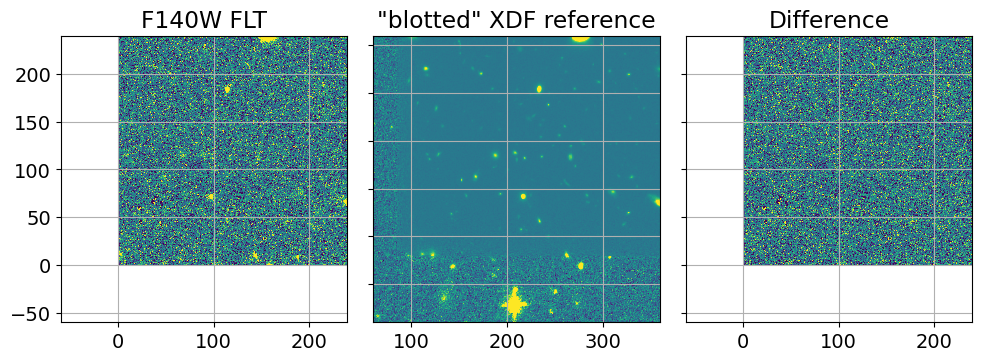

In [30]:
## Show the blotted reference direct image
f140w = pyfits.open('ibhj34h6q_flt.fits')
fig = plt.figure()

ax = fig.add_subplot(131) # FLT exposure
ax.imshow(f140w['SCI'].data, interpolation='Nearest', 
           origin='lower', vmin=-0.2, vmax=0.3, cmap='viridis')
ax.set_title('F140W FLT')

ax = fig.add_subplot(132) # Blotted reference image
blotted = flt.direct.data['REF']/flt.direct.ref_photflam
ax.imshow(blotted, interpolation='Nearest', 
           origin='lower', vmin=-0.2, vmax=0.3, cmap='viridis')
ax.set_title('"blotted" XDF reference')

ax = fig.add_subplot(133) # Grism
ax.imshow(f140w['SCI'].data - blotted[pad:-pad, pad:-pad],
           interpolation='Nearest', 
           origin='lower', vmin=-0.2, vmax=0.3, cmap='viridis')
ax.set_title('Difference')

for ax in fig.axes[1:]:
    ax.set_yticklabels([])

for i, ax in enumerate(fig.axes):
    ax.grid()
    offset = (i != 1)*pad # First is (1014,1014), others are (1014+2*pad, 1014+2*pad)
    ax.set_xlim(60-offset,360-offset)
    ax.set_ylim(60-offset,360-offset)

fig.tight_layout()

Since the grism configuration files are all defined in detector coordinates, the `blot_catalog` function is used to compute the detector positions of the objects detected in the rectified reference image.

In [31]:
# ## "blotted" SExtractor catalog, with catalog sky coordinates put into FLT frame
# ref_cat = Table.read(pyfits.open('hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.cat')[2])
# flt_cat = flt.blot_catalog(ref_cat, sextractor=True) # also stored in flt.catalog

In [32]:
flt.photutils_detection(detect_thresh=0, grow_seg=5, gauss_fwhm=2., 
                             verbose=True, save_detection=True)
flt_cat = flt.catalog

ibhj34h8q_flt: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
ibhj34h8q_flt: photutils.source_properties


        Use `~photutils.segmentation.SourceCatalog` instead. [grizli.utils]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]


Rename column: xcentroid -> x_flt
Rename column: ycentroid -> y_flt
ibhj34h8q_flt: photutils.source_properties - 772 objects
ibhj34h8q_flt: save ibhj34h8q_flt.detect_seg.fits, ibhj34h8q_flt.detect.cat


In [33]:
## Compute flat-spectrum model of bright sources
mask = flt_cat['mag'] < 25
print('N=%d' %(mask.sum()))
#flt.compute_full_model(compute_beams=['A','B','C','D','E','F'], mask=mask, verbose=False)
flt.compute_full_model(ids=flt_cat['id'][mask], mags=flt_cat['mag'][mask], verbose=True)

N=772


772it [00:06, 125.54it/s]


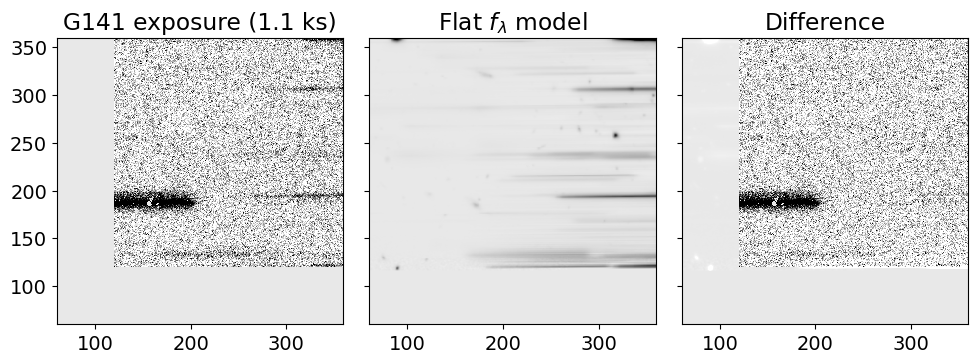

In [34]:
# Compare to the actual G141 exposure
fig = plt.figure()

ax = fig.add_subplot(131)
ax.imshow(flt.grism.data['SCI'], interpolation='Nearest', 
           origin='lower', vmin=-0.01, vmax=0.1, cmap='gray_r')
ax.set_title('G141 exposure (1.1 ks)')

ax = fig.add_subplot(132)
ax.imshow(flt.model, interpolation='Nearest', 
           origin='lower', vmin=-0.01, vmax=0.1, cmap='gray_r')
ax.set_title(r'Flat $f_\lambda$ model')

ax = fig.add_subplot(133)
ax.imshow(flt.grism.data['SCI'] - flt.model, interpolation='Nearest', 
           origin='lower', vmin=-0.01, vmax=0.1, cmap='gray_r')
ax.set_title('Difference')

for ax in fig.axes[1:]:
    ax.set_yticklabels([])

# show lower corner and how objects are modeled right to the edge
for ax in fig.axes:
    ax.set_xlim(60,360)
    ax.set_ylim(60,360)

fig.tight_layout()

The bright spectrum at lower left and the fainter spectrum at the top would not be modeled if just the single direct image were available.  However, they are included in the "padded" reference image and even the simple flat-spectrum model offers a reasonable first guess at the grism exposure model.

# Slitless spectra from multi-missions *JWST*/NIRISS and *WFIRST*

The examples below show how to first generate a "dummy" cutout image from the reference image, where the image itself is not cutout but rather the dummy images have appropriate WCS so that the `grizli.model.GrismFLT` will then be able to blot the reference and segmentation images.  

The image headers specify default values of the per-pixel sky backgrounds that are adopted with `make_fake_image(background='auto')`, that parameter can also be set to any desired float value.  The `make_fake_image` generating script has parameters `exptime` and `nexp` that are the used to define a simple noise model for the resulting simulation.  

$\sigma^2 = \mathrm{sky}\cdot\mathrm{exptime} + N_\mathrm{exp}\cdot\mathrm{readnoise}$

The value of $\sigma$ is stored in the `ERR` extension and random Gaussian deviates are put into the `SCI` extension of the `output` FITS files that are useful later for adding noise to the noiseless simulated spectra.

Again, these examples simulate grism exposures from the different missions/instruments with simple flat-spectrum SEDs with normalization set by the UDF F140W image (at 1.4 µm).  However, it is straightforward to use *any* spectrum (i.e., stellar or galaxy templates) for any given object model.

In [35]:
### Fake images, cendered in the UDF/XDF
ra, dec = 53.1592277508136, -27.782056346146
pa_aper = 128.589

# allow simulation of objects at the edges
pad=0 # pixels

mag_limit = 26 # faint limit for the simulation

EXPTIME = 1.e4 # 10 ks ~ 4 HST orbits
NEXP = 10      # divided between 10 exposures

## WFC3/IR G141

In [36]:
### WFC3/IR G141
h, wcs = grizli.fake_image.wfc3ir_header(filter='G141', ra=ra, dec=dec, pa_aper=pa_aper,
                                         flt='ibhj34h6q_flt.fits')

grizli.fake_image.make_fake_image(h, output='wfc3ir.fits', exptime=EXPTIME, nexp=NEXP, seed=1)

wfc3 = grizli.model.GrismFLT(grism_file='wfc3ir.fits', verbose=True, pad=pad,  
                           ref_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits')
                        #    seg_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_seg.fits')

wfc3.photutils_detection(detect_thresh=0, grow_seg=5, gauss_fwhm=2., 
                             verbose=True, save_detection=True)

# wfc3_cat = wfc3.blot_catalog(ref_cat, sextractor=True) # also stored in flt.catalog
wfc3_cat = wfc3.catalog

mask = wfc3_cat['mag'] < mag_limit
print('N=%d' %(mask.sum()))

#wfc3.compute_full_model(compute_beams=['A','B','C','D','E','F'], mask=mask, verbose=False)
wfc3.compute_full_model(ids=wfc3_cat['id'][mask], mags=wfc3_cat['mag'][mask], verbose=True)

 [astropy.io.fits.verify]


Image cutout: x=slice(1255, 4287, None), y=slice(1633, 4693, None)
wfc3ir.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits[0]
Using default C-based coordinate transformation...
wfc3ir: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)
wfc3ir: photutils.source_properties


        Use `~photutils.segmentation.SourceCatalog` instead. [grizli.utils]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]


Rename column: xcentroid -> x_flt
Rename column: ycentroid -> y_flt
wfc3ir: photutils.source_properties - 1281 objects
wfc3ir: save wfc3ir.detect_seg.fits, wfc3ir.detect.cat
N=1281


54it [00:00, 517.70it/s]

ID 37 not found in segmentation image

########################################## 
# ! Exception (2024-06-11 00:04:46.029)
#
# !Traceback (most recent call last):
# !  File "/Users/keith/miniconda3/envs/stenv/lib/python3.12/site-packages/grizli/model.py", line 419, in process_config
# !    self.flat_index = self.idx[dyc + self.x0[0], self.dxpix]
# !                      ~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# !IndexError: index 14 is out of bounds for axis 0 with size 14
# !
# !During handling of the above exception, another exception occurred:
# !
# !Traceback (most recent call last):
# !  File "/Users/keith/miniconda3/envs/stenv/lib/python3.12/site-packages/grizli/model.py", line 3173, in compute_model_orders
# !    beam = GrismDisperser(id=id,
# !           ^^^^^^^^^^^^^^^^^^^^^
# !  File "/Users/keith/miniconda3/envs/stenv/lib/python3.12/site-packages/grizli/model.py", line 289, in __init__
# !    self.process_config()
# !IndexError
# !
######################################### 



261it [00:01, 207.40it/s]


########################################## 
# ! Exception (2024-06-11 00:04:46.989)
#
# !Traceback (most recent call last):
# !  File "/Users/keith/miniconda3/envs/stenv/lib/python3.12/site-packages/grizli/model.py", line 419, in process_config
# !    self.flat_index = self.idx[dyc + self.x0[0], self.dxpix]
# !                      ~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# !IndexError: index 12 is out of bounds for axis 0 with size 12
# !
# !During handling of the above exception, another exception occurred:
# !
# !Traceback (most recent call last):
# !  File "/Users/keith/miniconda3/envs/stenv/lib/python3.12/site-packages/grizli/model.py", line 3173, in compute_model_orders
# !    beam = GrismDisperser(id=id,
# !           ^^^^^^^^^^^^^^^^^^^^^
# !  File "/Users/keith/miniconda3/envs/stenv/lib/python3.12/site-packages/grizli/model.py", line 289, in __init__
# !    self.process_config()
# !IndexError
# !
######################################### 



####################################

529it [00:02, 201.79it/s]

ID 497 not found in segmentation image


594it [00:02, 191.65it/s]

ID 571 not found in segmentation image
ID 606 not found in segmentation image


698it [00:03, 200.65it/s]

ID 666 not found in segmentation image


786it [00:03, 211.21it/s]

ID 749 not found in segmentation image

########################################## 
# ! Exception (2024-06-11 00:04:49.632)
#
# !Traceback (most recent call last):
# !  File "/Users/keith/miniconda3/envs/stenv/lib/python3.12/site-packages/grizli/model.py", line 419, in process_config
# !    self.flat_index = self.idx[dyc + self.x0[0], self.dxpix]
# !                      ~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# !IndexError: index 20 is out of bounds for axis 0 with size 20
# !
# !During handling of the above exception, another exception occurred:
# !
# !Traceback (most recent call last):
# !  File "/Users/keith/miniconda3/envs/stenv/lib/python3.12/site-packages/grizli/model.py", line 3173, in compute_model_orders
# !    beam = GrismDisperser(id=id,
# !           ^^^^^^^^^^^^^^^^^^^^^
# !  File "/Users/keith/miniconda3/envs/stenv/lib/python3.12/site-packages/grizli/model.py", line 289, in __init__
# !    self.process_config()
# !IndexError
# !
######################################### 


1039it [00:05, 199.05it/s]


########################################## 
# ! Exception (2024-06-11 00:04:50.875)
#
# !Traceback (most recent call last):
# !  File "/Users/keith/miniconda3/envs/stenv/lib/python3.12/site-packages/grizli/model.py", line 419, in process_config
# !    self.flat_index = self.idx[dyc + self.x0[0], self.dxpix]
# !                      ~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# !IndexError: index 18 is out of bounds for axis 0 with size 18
# !
# !During handling of the above exception, another exception occurred:
# !
# !Traceback (most recent call last):
# !  File "/Users/keith/miniconda3/envs/stenv/lib/python3.12/site-packages/grizli/model.py", line 3173, in compute_model_orders
# !    beam = GrismDisperser(id=id,
# !           ^^^^^^^^^^^^^^^^^^^^^
# !  File "/Users/keith/miniconda3/envs/stenv/lib/python3.12/site-packages/grizli/model.py", line 289, in __init__
# !    self.process_config()
# !IndexError
# !
######################################### 




1101it [00:05, 199.35it/s]

ID 1065 not found in segmentation image


1250it [00:06, 202.71it/s]

ID 1213 not found in segmentation image

########################################## 
# ! Exception (2024-06-11 00:04:51.976)
#
# !Traceback (most recent call last):
# !  File "/Users/keith/miniconda3/envs/stenv/lib/python3.12/site-packages/grizli/model.py", line 419, in process_config
# !    self.flat_index = self.idx[dyc + self.x0[0], self.dxpix]
# !                      ~~~~~~~~^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# !IndexError: index 16 is out of bounds for axis 0 with size 16
# !
# !During handling of the above exception, another exception occurred:
# !
# !Traceback (most recent call last):
# !  File "/Users/keith/miniconda3/envs/stenv/lib/python3.12/site-packages/grizli/model.py", line 3173, in compute_model_orders
# !    beam = GrismDisperser(id=id,
# !           ^^^^^^^^^^^^^^^^^^^^^
# !  File "/Users/keith/miniconda3/envs/stenv/lib/python3.12/site-packages/grizli/model.py", line 289, in __init__
# !    self.process_config()
# !IndexError
# !
######################################### 

1281it [00:06, 204.78it/s]


## JWST NIRISS

(Seems to be broken in 2021 as the header doesn't work with the `jwst` pipeline data model)

In [37]:
try:
    import jwst
    h, wcs = grizli.fake_image.niriss_header(filter='F150W', ra=ra, dec=dec, pa_aper=pa_aper)
    grizli.fake_image.make_fake_image(h, output='niriss.fits', exptime=EXPTIME, nexp=NEXP)

    niriss = grizli.model.GrismFLT(grism_file='niriss.fits', verbose=True, pad=pad,  
                               ref_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits') 
                            #    seg_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_seg.fits')

    niriss.photutils_detection(detect_thresh=0, grow_seg=5, gauss_fwhm=2., 
                             verbose=True, save_detection=True)

    # niriss_cat = niriss.blot_catalog(ref_cat, sextractor=True) # also stored in flt.catalog
    # niriss.catalog = niriss_cat

    niriss_cat = niriss.catalog

    mask = niriss_cat['mag'] < mag_limit
    print('N=%d' %(mask.sum()))
    #niriss.compute_full_model(compute_beams=['A','B','C','D','E'], mask=mask, verbose=False)
    niriss.compute_full_model(ids=niriss_cat['id'][mask], mags=niriss_cat['mag'][mask])
except Exception as e:
    raise e
    print('Skip JWST')

 [astropy.io.fits.verify]


 !! Shift GR150R.F150W.220725.conf along dispersion
 ! Scale 0th order (B) by an additional x 1.5
Image cutout: x=slice(1223, 4369, None), y=slice(1612, 4760, None)
niriss.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits[0]
Using default C-based coordinate transformation...
niriss: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=0.0)


niriss: photutils.source_properties


        Use `~photutils.segmentation.SourceCatalog` instead. [grizli.utils]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]


Rename column: xcentroid -> x_flt
Rename column: ycentroid -> y_flt
niriss: photutils.source_properties - 5217 objects
niriss: save niriss.detect_seg.fits, niriss.detect.cat
N=5217
ID 67 not found in segmentation image
ID 90 not found in segmentation image
ID 153 not found in segmentation image
ID 157 not found in segmentation image
ID 279 not found in segmentation image
ID 311 not found in segmentation image
ID 322 not found in segmentation image
ID 469 not found in segmentation image
ID 626 not found in segmentation image
ID 829 not found in segmentation image
ID 1088 not found in segmentation image
ID 1104 not found in segmentation image
ID 1293 not found in segmentation image
ID 1763 not found in segmentation image
ID 2614 not found in segmentation image
ID 2681 not found in segmentation image
ID 2823 not found in segmentation image
ID 2868 not found in segmentation image
ID 2938 not found in segmentation image

########################################## 
# ! Exception (2024-06-11 

# ROMAN SIM HERE ---------------------------------------------------------------

## Roman/G150 Grism

*Note:* The default simulation here is significantly deeper than the baseline High Latitude Survey


In [38]:
### This cell was skipped above, but sets needed variables

### Fake images, cendered in the UDF/XDF
ra, dec = 53.1592277508136, -27.782056346146
pa_aper = 128.589

# allow simulation of objects at the edges
pad=0 # pixels

mag_limit = 28 # faint limit for the simulation

EXPTIME = 1.e4 # 10 ks ~ 4 HST orbits
NEXP = 10      # divided between 10 exposures


# cat, seg = detect_with_photutils

# cat.write()

In [39]:
# Generate crude configuration files from Pandeia outputs
# Requires pandia.engine and the roman data files
from grizli import GRIZLI_PATH
conf_file = os.path.join(GRIZLI_PATH, 'CONF', 'Roman.G150.conf')

if not os.path.exists(conf_file):
    import pandeia
    %env pandeia_refdata=/Users/keith/astr/research_astr/pandeia_data-3.1_roman/
    %env PYSYN_CDBS=/Users/keith/astr/research_astr/grp/redcat/trds
    grizli.fake_image.make_roman_config(save_to_conf=True)

# I had to change 
# Tracked Source Code Changes
# Pandeia 
# pandeia.engine.roman.py: line 38 & 39 --> self.instrument['detector'] = self.aperture_config[self.get_aperture()]['detector']
# pandeia.engine.instrument.py: line 319 --> added a line to define self.instrument['aperture']='spectroscopy' to prevent 'any' keyError


In [40]:
import pandeia
%env pandeia_refdata=/Users/keith/astr/research_astr/pandeia_data-3.1_roman/
%env PYSYN_CDBS=/Users/keith/astr/research_astr/grp/redcat/trds
grizli.fake_image.make_roman_config(save_to_conf=True)

env: pandeia_refdata=/Users/keith/astr/research_astr/grizbox/pandeia_data-3.1_roman/
env: PYSYN_CDBS=/Users/keith/astr/research_astr/grizbox/grp/redcat/trds


        Use "format" instead. [pandeia.engine.extinction]


Sensitivity file:  /Users/keith/grizli/CONF/Roman.G150.v3.1.sens.fits
Config file:  /Users/keith/grizli/CONF/Roman.G150.conf


(<Table length=5250>
 WAVELENGTH SENSITIVITY       ERROR      
  float64     float64        float64     
 ---------- ----------- -----------------
     9000.0         0.0 221875084475004.4
     9002.0         0.0 221875084475004.4
     9004.0         0.0 221875084475004.4
     9006.0         0.0 221875084475004.4
     9008.0         0.0 221875084475004.4
     9010.0         0.0 221875084475004.4
     9012.0         0.0 221875084475004.4
     9014.0         0.0 221875084475004.4
     9016.0         0.0 221875084475004.4
     9018.0         0.0 221875084475004.4
        ...         ...               ...
    19480.0         0.0 221875084475004.4
    19482.0         0.0 221875084475004.4
    19484.0         0.0 221875084475004.4
    19486.0         0.0 221875084475004.4
    19488.0         0.0 221875084475004.4
    19490.0         0.0 221875084475004.4
    19492.0         0.0 221875084475004.4
    19494.0         0.0 221875084475004.4
    19496.0         0.0 221875084475004.4
    19498.0  

In [41]:
### Roman/G150 grism.  
h, wcs = grizli.fake_image.roman_header(ra=ra, dec=dec, pa_aper=pa_aper, naxis=(1180,1180))
grizli.fake_image.make_fake_image(h, output='roman.fits', exptime=EXPTIME, nexp=NEXP)

roman = grizli.model.GrismFLT(grism_file='roman.fits', verbose=True, pad=pad,  
                               ref_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits')
                            #    seg_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_seg.fits')

roman.photutils_detection(detect_thresh=0, grow_seg=5, gauss_fwhm=2., 
                             verbose=True, save_detection=True)

# roman_cat = roman.blot_catalog(ref_cat, sextractor=True)
roman_cat = roman.catalog 

mask = roman_cat['mag'] < mag_limit
print('N=%d' %(mask.sum()))
#wfirst.compute_full_model(compute_beams=['A'], mask=mask, verbose=False)
roman.compute_full_model(ids=roman_cat['id'][mask], mags=roman_cat['mag'][mask], verbose=True)

Image cutout: x=slice(1275, 4315, None), y=slice(1666, 4706, None)
roman.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits[0]
Using default C-based coordinate transformation...
roman: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=26.8)


 [astropy.io.fits.verify]
        Use `~photutils.segmentation.SourceCatalog` instead. [grizli.utils]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]


roman: photutils.source_properties


        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]


Rename column: xcentroid -> x_flt
Rename column: ycentroid -> y_flt
roman: photutils.source_properties - 1751 objects
roman: save roman.detect_seg.fits, roman.detect.cat
N=243


243it [00:00, 883.31it/s]

ID 1417 not found in segmentation image


### Roman HLS depth

In [42]:
# HLS exposure times

hdu, wcs = grizli.fake_image.roman_hls_image(ra=ra, dec=dec, pa_aper=pa_aper, naxis=(1180,1180), output='roman.fits')


hls = grizli.model.GrismFLT(grism_file='roman.fits', verbose=True, pad=pad,  
                               ref_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits')
                            #    seg_file='hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_seg.fits')

hls.photutils_detection(detect_thresh=0, grow_seg=5, gauss_fwhm=2., 
                             verbose=True, save_detection=True)

# hls_cat = hls.blot_catalog(ref_cat, sextractor=True) 
hls_cat = hls.catalog

mask = hls_cat['mag'] < mag_limit
print('N=%d' %(mask.sum()))
#wfirst.compute_full_model(compute_beams=['A'], mask=mask, verbose=False)
hls.compute_full_model(ids=hls_cat['id'][mask], mags=hls_cat['mag'][mask], verbose=True)

 [astropy.io.fits.verify]


Image cutout: x=slice(1275, 4315, None), y=slice(1666, 4706, None)
roman.fits / blot reference hlsp_xdf_hst_wfc3ir-60mas_hudf_f140w_v1_sci.fits[0]
Using default C-based coordinate transformation...


        Use `~photutils.segmentation.SourceCatalog` instead. [grizli.utils]
        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]


roman: photutils.detect_sources (detect_thresh=0.0, grow_seg=5, gauss_fwhm=2.0, ZP=26.8)
roman: photutils.source_properties


        Use `~photutils.segmentation.SourceCatalog` instead. [photutils.segmentation.properties]


Rename column: xcentroid -> x_flt
Rename column: ycentroid -> y_flt
roman: photutils.source_properties - 1764 objects
roman: save roman.detect_seg.fits, roman.detect.cat
N=1271


129it [00:00, 1285.53it/s]

ID 28 not found in segmentation image
ID 33 not found in segmentation image
ID 54 not found in segmentation image
ID 55 not found in segmentation image


716it [00:00, 1086.37it/s]

ID 755 not found in segmentation image


1045it [00:00, 1085.29it/s]

ID 1227 not found in segmentation image
ID 1385 not found in segmentation image
ID 1408 not found in segmentation image


1271it [00:01, 1094.98it/s]


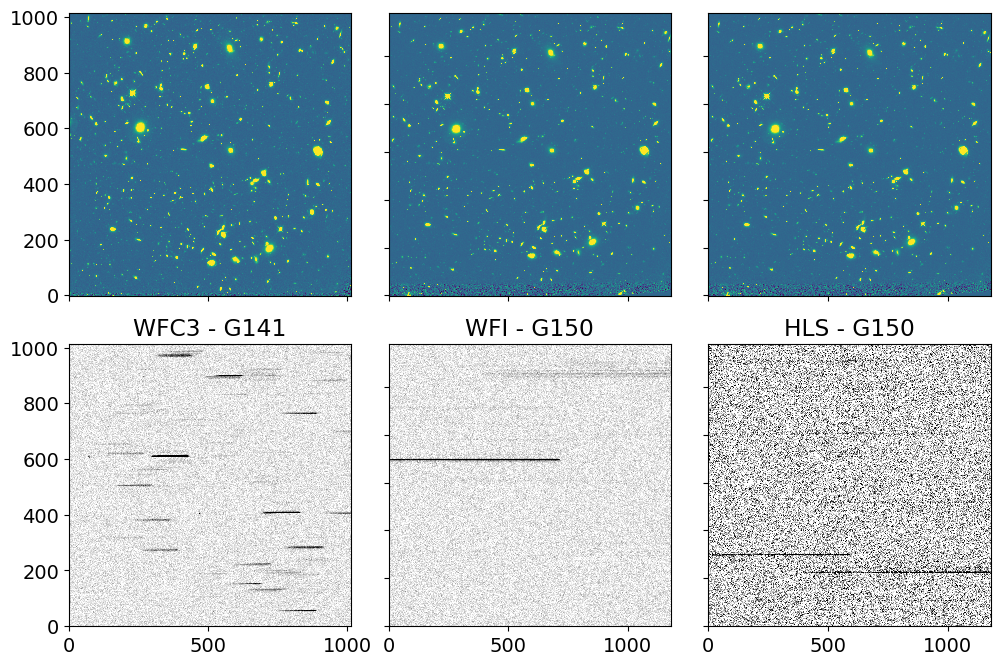

In [43]:
### Show them!
# Compare to the actual G141 exposure
fig = plt.figure(figsize=[10,10.*2/3])

for i, sim, key in zip([0, 1,2], [wfc3, roman, hls], ['WFC3', 'WFI','HLS']):
    # Direct
    axt = fig.add_subplot(231+i)
    axt.imshow(sim.direct.data['REF']/sim.direct.ref_photflam, interpolation='Nearest', 
           origin='lower', vmin=-0.1, vmax=0.2, cmap='viridis')
    axt.set_xticklabels([])
    
    # Grism
    axb = fig.add_subplot(234+i)
    axb.imshow(sim.model + sim.grism.data['SCI'], interpolation='Nearest', 
           origin='lower', vmin=-0.01, vmax=0.1, cmap='gray_r')
    axb.set_title('%s - %s' %(key, sim.grism.filter))
    
    if i > 0:
        axt.set_yticklabels([])
        axb.set_yticklabels([])

fig.tight_layout(pad=0.5)

The NIRISS spectra with the blocking filters take up much less detector real estate than the WFC3/G141 and (especially) the WFIRST spectra.

Pull out an object and simulate a spectrum with lines
-----------------------------------------------------

As in the other demonstration notebooks, we now show how to "extract" a single object spectrum and compute a more detailed spectral model for that object, in this case a young star-forming galaxy with strong emission lines.

In [44]:
raise Exception('Pause here')

In [45]:
wfc3.object_dispersers[40][2]['A']

In [46]:
## Find the object ID near coordinates (r0,d0), 
## SExtractor IDs might not be constant across platforms
r0, d0 = 53.159868, -27.785791
r0, d0 = 53.160473, -27.786294 # H~23, works well
#r0, d0 = 53.155611, -27.779308 # bright
ref_cat=wfc3_cat
dr = np.sqrt((ref_cat['x_flt'].value-r0)**2*np.cos(d0/180*np.pi)**2 + 
             (ref_cat['y_flt'].value-d0)**2)*3600
id = ref_cat['id'][np.argmin(dr)]
obj_mag = ref_cat['mag'][np.argmin(dr)]
print('ID:%d, mag=%.2f' %(id, obj_mag))

beams = OrderedDict()

for i, sim, key in zip([0,1,2], [wfc3, roman, hls], ['WFC3','WFI','HLS']):
    ix = sim.catalog['id'] == id
    x0, y0 = sim.catalog['x_flt'][ix][0], sim.catalog['y_flt'][ix][0]
    print(f'{key} {sim.grism.filter} xy = ({x0:.1f}, {y0:.1f})')
    
    #dim = 18*0.135/sim.flt_wcs.pscale 
    #beam = grizli.model.BeamCutout(id=id, x=x0, y=y0, 
    #                               cutout_dimensions=np.cast[int]((dim, dim)), 
    #                               conf=sim.conf, GrismFLT=sim)

    cutout = grizli.model.BeamCutout(sim, sim.object_dispersers[id][2]['A']) 

    cutout.beam.compute_model()  
    cutout.contam = cutout.beam.cutout_from_full_image(sim.model)
    if id in sim.object_dispersers:
        cutout.contam -= cutout.beam.model
    
    beams[key] = cutout

ID:2, mag=0.57
WFC3 G141 xy = (42.3 pix, 4.7 pix)


KeyError: 2

In [ ]:
## Spectrum with lines & noise
spectrum_file = os.path.join(os.path.dirname(grizli.__file__), 'data/templates/erb2010.dat')
erb = np.loadtxt(spectrum_file, unpack=True)
z = 2.0 # test redshift

## normalize spectrum to unity to use normalization defined in the direct image
import pysynphot as S
spec = S.ArraySpectrum(erb[0], erb[1], fluxunits='flam')
spec = spec.redshift(z).renorm(1., 'flam', S.ObsBandpass('wfc3,ir,f140w'))
spec.convert('flam') # bug in pysynphot, now units being converted automatically above? (11/10/16)

fig = plt.figure()
for i, key in enumerate(beams.keys()):
    #     beams[key].compute_model(beams[key].thumb, id=beams[key].id, 
    #                              xspec=spec.wave, yspec=spec.flux)
    beams[key].beam.compute_model(spectrum_1d=[spec.wave, spec.flux], is_cgs=False) 
    
    axl = fig.add_subplot(321+i*2)
    axl.imshow(beams[key].model + beams[key].grism.data['SCI']*1, interpolation='Nearest', 
           origin='lower', vmin=-0.006, vmax=0.16, cmap='gray_r', aspect='auto')
    
    axr = fig.add_subplot(321+i*2+1)
    axr.imshow(beams[key].contam + beams[key].grism.data['SCI'] + beams[key].model, 
               interpolation='Nearest', 
               origin='lower', vmin=-0.006, vmax=0.16, cmap='gray_r', aspect='auto')
    
    axl.set_ylabel('%s - %s' %(key, beams[key].grism.filter))
    if 1:        
        for ax in [axl, axr]:
            ax.set_yticklabels([])
            beams[key].beam.twod_axis_labels(wscale=1.e4, mpl_axis=ax)
            beams[key].beam.twod_xlim(1.3,1.75, wscale=1.e4, mpl_axis=ax)
            if i < 2:
                ax.set_xticklabels([])
            else:
                ax.set_xlabel(r'$\lambda$')

fig.tight_layout(pad=0.5)

In [ ]:
### Plot 1D spectra
for i, key in enumerate(['WFC3','WFI']):
    if i == 1:
        scl = 1.
    else:
        scl = 1.
    
    print(key, scl)
    w, f, e = beams[key].beam.optimal_extract(beams[key].model+beams[key].grism.data['SCI'], bin=0)
    plt.step(w/1.e4, f*scl, label='%s - %s' %(key, beams[key].grism.filter), 
             alpha=0.6)

plt.legend(fontsize=14)
plt.xlim(0.9, 2.05)
plt.xlabel(r'$\lambda$')

The differences between the properties of the slitless spectra from the various instruments/telescopes are dramatic.  With the large telescope aperture, the NIRISS spectrum is clearly the highest S/N in both the line and continuum, though at quite low spectral resolution.  In practice the effective NIRISS spectral resolution may be a bit better than this simulation would suggest, where the object morphology is barely, if at all, resolved at *HST* resolution.

(**05.2021: NIRISS not shown while the simulation is broken**)

The G141 and WFIRST spectra show similar count rates in the line, but at high spectral resolution the WFIRST continuum is essentially lost (at native resolution).  Though with the huge spectra the WFIRST contamination can be problematic, the [OIII] and H$\beta$ lines are nicely resolved and poke out above the smooth continuum.

# Compare Grizli and Pandeia simulations for Roman

In [ ]:
import os
import grizli
import glob

try:
    import pandeia
except:
    !pip install pandeia.engine==1.6

pandeia_refdata = os.getenv('pandeia_refdata')
if not pandeia_refdata:
    pwd = os.getcwd()
    pandeia_refdata = os.path.join(grizli.GRIZLI_PATH, 'pandeia_data-1.6_roman')
    if not os.path.exists(pandeia_refdata):
        os.mkdir(pandeia_refdata)

    os.chdir(grizli.GRIZLI_PATH)
    if len(glob.glob(pandeia_refdata+'/*')) == 0:
        os.system('wget https://s3.amazonaws.com/grizli-v1/Demo/pandeia_data-1.6_roman.tar.gz')
        os.system('tar xzf pandeia_data-1.6_roman.tar.gz')
        os.remove('pandeia_data-1.6_roman.tar.gz')

    os.chdir(pwd)
    os.environ['pandeia_refdata'] = pandeia_refdata

if os.path.exists('/Users/gbrammer'):
    %env pandeia_refdata=/Users/gbrammer/Research/Roman/pandeia_data-1.6_roman/
else:
    print(f'pandeia_refdata = {pandeia_refdata}')


In [ ]:
from astropy.table import Table
import astropy.time
import pandeia.engine

from pandeia.engine.perform_calculation import perform_calculation
from pandeia.engine.calc_utils import (get_telescope_config, 
                                       get_instrument_config, 
                                       build_default_calc,
                                       build_default_source)

from pandeia.engine.io_utils import read_json, write_json

calc = build_default_calc('roman','wfi','spectroscopy')

# HLS simulation
calc['configuration']['instrument']['filter'] = None
calc['configuration']['instrument']['aperture'] = "any"
calc['configuration']['instrument']['disperser'] = "g150"
calc['configuration']['detector']['ngroup'] = 13 # groups per integration
calc['configuration']['detector']['nint'] = 1 # integrations per exposure
calc['configuration']['detector']['nexp'] = 1 # exposures
calc['configuration']['detector']['readmode'] = "medium8"
calc['configuration']['detector']['subarray'] = "1024x1024"

calc['scene'][0]['spectrum']['normalization']['norm_fluxunit'] = 'flam'

input_flux = 1.e-19
calc['scene'][0]['spectrum']['normalization']['norm_flux'] = input_flux
calc['scene'][0]['spectrum']['sed']['unit'] = 'flam'

# x,y location to extract, in arcsec
calc['strategy']['target_xy'] = [0.0,0.0] 
# radius of extraction aperture, in arcsec
calc['strategy']['aperture_size'] = 0.6 
# inner and outer radii of background subtraction annulus, in arcsec
calc['strategy']['sky_annulus'] = [1.2,1.8] 


In [ ]:
### Simulated spectrum in Pandeia
import astropy.units as u

spec = S.ArraySpectrum(erb[0], erb[1], fluxunits='flam')
spec = spec.redshift(z).renorm(beams['WFC3'].beam.total_flux, 'flam', S.ObsBandpass('wfc3,ir,f140w'))

#spec = S.FlatSpectrum(1.e-16, waveunits='angstrom', fluxunits='flam')

spec.convert('mjy') # bug in pysynphot, now units being converted automatically above? (11/10/16)

calc['scene'][0]['spectrum']['normalization']['type'] = 'none'
calc['scene'][0]['spectrum']['sed']['sed_type'] = 'input'
calc['scene'][0]['spectrum']['sed']['spectrum'] = (spec.wave/1.e4, spec.flux)

# Run calculation
results = perform_calculation(calc)

In [ ]:
results['1d'].keys()

In [ ]:
beam = beams['HLS']

spec.convert('flam') 
beam.beam.compute_model(spectrum_1d=[spec.wave, spec.flux], is_cgs=True)

total_var = 1/beam.ivar*beam.grism.exptime**2 + beam.model * beam.grism.exptime
total_ivar = beam.grism.exptime**2 / total_var
total_ivar[beam.ivar == 0] = 0

w, f, e = beam.beam.optimal_extract(beam.model, bin=1, ivar=total_ivar)
w, fa, ea = beam.beam.trace_extract(beam.model, r=int(0.6/0.11), bin=1, ivar=total_ivar)


In [ ]:
fig, axes = plt.subplots(1,2,figsize=(12,6), sharex=True)

pspec = results['1d']['extracted_flux']
axes[0].plot(*pspec, label=f'Pandeia {pandeia.engine.__version__}')
axes[0].plot(w/1.e4, f, label='HLS grizli simulation (optimal)')

axes[0].set_ylim(0.005, 0.8)
axes[0].set_ylabel('Flux on the detector [e-/s]')

# Uncertainties
pspec = results['1d']['extracted_noise']
axes[1].plot(*pspec, label=f'Pandeia uncertainty')

pandeia_rms = np.std(results['2d']['detector'])
aper_rms = np.sqrt(pandeia_rms**2*2*calc['strategy']['aperture_size']/0.11)

axes[1].plot(w/1.e4, e, label='Grizli unc. (optimal)')
axes[1].plot(w/1.e4, ea, label='Grizli unc. (trace aper)')

axes[1].hlines(aper_rms, *axes[1].get_xlim(), color='r', 
               label='Expected R={0}" aper rms'.format(calc['strategy']['aperture_size']))

axes[1].set_ylim(0.005, 0.8)

for ax in axes:
    ax.grid()
    ax.semilogy()
    ax.legend()
    ax.set_xlim(1.4, 1.6)

    ax.set_xlabel(r'$\lambda\,[\mu\mathrm{m}]$')


In [ ]:
# Not clear why Pandeia 1D uncertainties significantly higher since 2D variance is matched by design
print(' Pandeia 2D rms: {0:.4f}'.format(pandeia_rms))
print('  Grizli 2D rms: {0:.4f}'.format(1/np.sqrt(np.median(total_ivar))))

print('Expected 1D rms: {0:.4f}'.format(aper_rms))